## Trend Segmentation using Smoothing, Velocity

# 1. ETL The Data

## 1.1 Load libraries
First we import the libraries we will be using

In [1]:
import numpy 

In [2]:
import pandas

In [3]:
import matplotlib.pyplot as pyplot

## 1.2 Load the data

In [4]:
from Relay import Utilities

# Read the file into a dataframe
file_path = "nasdaq_2019.csv"
converter_mapping = {
    "date": Utilities.convert_date_string_to_date
}
nasdaq_dataframe = pandas.read_csv(file_path, converters=converter_mapping)

# Sort based on the date column
nasdaq_dataframe = nasdaq_dataframe.sort_values("date")
nasdaq_dataframe.head()

,ticker,interval,date,open,high,low,close,volume
96004,RAND,D,2019-01-01,2.50,2.50,2.50,2.50,0
95734,OPTT,D,2019-01-01,0.34,0.34,0.34,0.34,0
95735,ORBC,D,2019-01-01,8.26,8.26,8.26,8.26,0
95736,ORG,D,2019-01-01,24.49,24.49,24.49,24.49,0
95737,ORGS,D,2019-01-01,4.68,4.68,4.68,4.68,0


## 1.3 Get a list of tickers
Next we get a list of the tickers. This is likely something we should have on hand before we run the algos.

We will use the tickers as the names of the queues. As we need to attach listeners to the queues, again we should know the names of the tickers ahead of time.

In [5]:
tickers = pandas.Series(nasdaq_dataframe["ticker"].unique()).sort_values()
tickers.head()

2113    AABA
2114     AAL
2115    AAME
2116    AAOI
2117    AAON
dtype: object

To make our lives easier we will only use one ticker at a time

In [6]:
mock_tickers = pandas.Series(["AABA"])
mock_tickers

0    AABA
dtype: object

# Visualize the data

In [7]:
aaba_dataframe = nasdaq_dataframe.loc[nasdaq_dataframe.ticker == "AABA"]
aaba_dataframe.index = range(0, aaba_dataframe.shape[0]) # reset the index to make our life easier

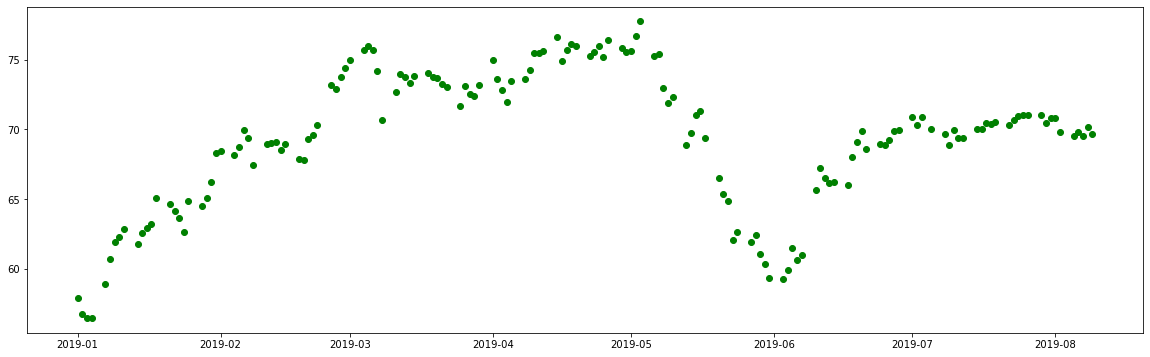

In [12]:
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.scatter(aaba_dataframe["date"], aaba_dataframe["open"], color="green")

# Analye the data and generate signals

In [17]:
# Generate a list of messages
n = aaba_dataframe.shape[0]
messages = []
for x in range(0, n):
    df = aaba_dataframe.loc[[x]]
    message = df.to_json(date_unit='ns', orient='records')
    messages.append(message)

# Create a dataframe to store the results
df = pandas.DataFrame()

# Setup a mock relay
class DummyRelay():
    def process(self, *args, **kwargs):

        message = kwargs["message"]
        df = pandas.read_json(message, orient='records')
        if self.dataframe.shape == (0, 0):
            # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html
            self.dataframe = df
        else:
            self.dataframe.loc[self.dataframe.shape[0]] = df.loc[0]
            
relay = DummyRelay()
relay.dataframe = pandas.DataFrame()

# Setup a listener to process the messages
from Relay.ActiveMQ.ActiveMQRelayListener import ActiveMQRelayListener
relay.listener = ActiveMQRelayListener()

# Add callbacks to the listener
from Relay.Callbacks.CallbackMapping import CallbackMapping
import Relay.Callbacks.PandasCallbacks as PandasCallbacks

relay.listener.callback_mappings.append(CallbackMapping(relay.process, [], {}))
relay.listener.callback_mappings.append(CallbackMapping(
    PandasCallbacks.calculate_exponential_moving_average,
    [],
    {
        "column_name": "open",
        "new_column_suffix": "_ewma",
        "window": 3,
        "decay": 0.9,
        "relay": relay
    }
))
relay.listener.callback_mappings.append(CallbackMapping(
    PandasCallbacks.calculate_velocity,
    [],
    {
        "column_name": "open_ewma",
        "new_column_suffix": "_v",
        "relay": relay
    }
))
relay.listener.callback_mappings.append(CallbackMapping(
    PandasCallbacks.calculate_inflection_point,
    [],
    {
        "column_name": "open_ewma_v",
        "new_column_suffix": "_ip",
        "relay": relay
    }
))
relay.listener.callback_mappings.append(CallbackMapping(
    PandasCallbacks.calculate_ordinals,
    [],
    {
        "column_name": "date",
        "new_column_suffix": "_ord",
        "relay": relay
    }
))
relay.listener.callback_mappings.append(CallbackMapping(
    PandasCallbacks.linear_regression_prediction,
    [],
    {
        "column_name": "open",
        "new_column_suffix": "_pred",
        "train_x_name": "date_ord",
        "train_y_name": "open",
        "ip_column_name": "open_ewma_v_ip",
        "relay": relay
    }
))
relay.listener.callback_mappings.append(CallbackMapping(
    PandasCallbacks.determine_buy_sell_signal,
    [],
    {
        "column_name": "open",
        "pred_column_name": "open_pred",
        "relay": relay
    }
))


# Process the messages
for message in messages:
    headers = [None]
    relay.listener.on_message(headers, message)


aaba_dataframe = relay.dataframe

In [21]:
aaba_dataframe.head(10)

,ticker,interval,date,open,high,low,close,volume,open_ewma,open_ewma_v,open_ewma_v_ip,date_ord,open_pred,open_buy,open_sell
0,AABA,D,2019-01-01,57.94,57.94,57.94,57.94,0,NaN,NaN,0,737060,NaN,NaN,NaN
1,AABA,D,2019-01-02,56.78,58.01,56.47,57.49,10532400,NaN,NaN,0,737061,NaN,NaN,NaN
2,AABA,D,2019-01-03,56.48,56.85,55.09,55.53,8506900,56.480000,NaN,0,737062,NaN,NaN,NaN
3,AABA,D,2019-01-04,56.50,59.38,56.50,58.72,9438700,56.614391,0.134391,1,737063,NaN,NaN,NaN
4,AABA,D,2019-01-07,58.90,60.20,58.45,59.64,9004700,57.844129,1.229738,0,737066,NaN,NaN,NaN
5,AABA,D,2019-01-08,60.70,61.41,59.50,61.04,6918600,59.456595,1.612466,0,737067,NaN,NaN,NaN
6,AABA,D,2019-01-09,61.90,63.47,61.72,62.94,11313600,60.893827,1.437232,0,737068,60.353846,NaN,61.90
7,AABA,D,2019-01-10,62.31,63.15,61.95,63.11,6199700,61.801292,0.907465,0,737069,61.642857,NaN,62.31
8,AABA,D,2019-01-11,62.87,63.57,62.53,62.88,3692300,62.474541,0.673249,0,737070,62.523585,NaN,62.87
9,AABA,D,2019-01-14,61.77,62.46,61.15,62.29,8761100,62.133585,-0.340956,1,737073,NaN,NaN,NaN


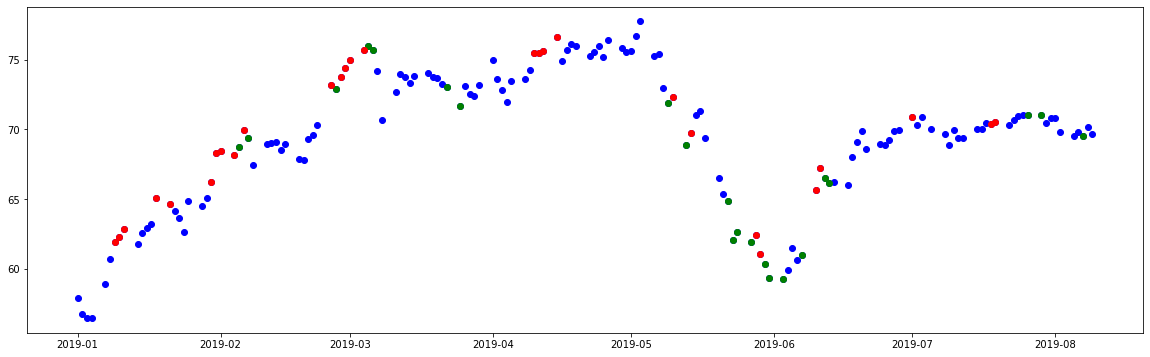

In [18]:

figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.scatter(aaba_dataframe["date"], aaba_dataframe["open"], color="blue")
axis.scatter(aaba_dataframe["date"], aaba_dataframe["open_buy"], color="green")
axis.scatter(aaba_dataframe["date"], aaba_dataframe["open_sell"], color="red")